In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import apply_cats, proc_df
from fastai.column_data import *
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import dill as pickle
from IPython.display import display

pd.options.display.max_columns = None
import numpy as np
np.set_printoptions(threshold=50, edgeitems=20)
data_path=Path('data/')
PATH = data_path
SK_ID_CURR = "SK_ID_CURR"

In [3]:
cred_card_bal = pickle.load(open('data/credit_card_balance','rb'))
pos_cash_bal = pickle.load(open('data/POS_CASH_balance','rb'))
prev = pickle.load(open('data/previous_application','rb'))
bureau_bal = pickle.load(open('data/bureau_balance','rb'))
install = pickle.load(open('data/installments_payments','rb'))
bureau = pickle.load(open('data/bureau','rb'))
application_train = pickle.load(open('data/application_train','rb'))
application_test = pickle.load(open('data/application_test','rb'))

In [4]:
merged_df = pickle.load(open('data/merged_df.pickle','rb'))

In [5]:
len(merged_df.columns)

213

In [6]:
prev.sample(10)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1403575,2386847,318661,Consumer loans,10125.900,150678.0,99954.0,60273.0,150678.0,THURSDAY,16,Y,1,0.409686,NaN,NaN,XAP,Approved,-1035,XNA,XAP,Children,New,Computers,POS,XNA,Regional / Local,150,Consumer electronics,12.0,middle,POS household with interest,365243.0,-1004.0,-674.0,-704.0,-695.0,0.0
1015955,2539072,446597,Cash loans,32811.750,225000.0,275373.0,NaN,225000.0,WEDNESDAY,11,Y,1,NaN,NaN,NaN,Journey,Approved,-512,Cash through the bank,XAP,NaN,New,XNA,Cash,walk-in,Credit and cash offices,100,XNA,12.0,high,Cash Street: high,365243.0,-482.0,-152.0,-212.0,-207.0,1.0
621083,1879930,111997,Consumer loans,14257.080,89428.5,88213.5,9000.0,89428.5,THURSDAY,10,Y,1,0.100828,NaN,NaN,XAP,Approved,-82,Cash through the bank,XAP,NaN,Repeater,Photo / Cinema Equipment,POS,XNA,Country-wide,110,Connectivity,8.0,high,POS mobile with interest,365243.0,-47.0,163.0,365243.0,365243.0,0.0
359637,1866695,102574,Cash loans,NaN,0.0,0.0,NaN,NaN,WEDNESDAY,14,Y,1,NaN,NaN,NaN,XNA,Canceled,-280,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
365882,2543674,199921,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,7,Y,1,NaN,NaN,NaN,XNA,Canceled,-49,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1325411,2715956,416632,Revolving loans,2250.000,45000.0,45000.0,NaN,45000.0,FRIDAY,11,Y,1,NaN,NaN,NaN,XAP,Approved,-182,XNA,XAP,Unaccompanied,Repeater,XNA,Cards,walk-in,Credit and cash offices,-1,XNA,0.0,XNA,Card Street,365243.0,365243.0,365243.0,365243.0,365243.0,0.0
134879,2730546,187093,Consumer loans,6328.710,66996.0,69246.0,0.0,66996.0,MONDAY,19,Y,1,0.000000,NaN,NaN,XAP,Approved,-11,Cash through the bank,XAP,Family,Repeater,Computers,POS,XNA,Country-wide,1500,Consumer electronics,12.0,low_action,POS household without interest,365243.0,365243.0,349.0,365243.0,365243.0,1.0
148354,1767182,439210,Consumer loans,14559.345,134955.0,121459.5,13495.5,134955.0,WEDNESDAY,12,Y,1,0.108909,NaN,NaN,XAP,Approved,-1076,Cash through the bank,XAP,NaN,New,Mobile,POS,XNA,Regional / Local,15,Consumer electronics,12.0,high,POS other with interest,365243.0,-1041.0,-711.0,-711.0,-708.0,0.0
392240,1129787,250409,Consumer loans,5212.080,115695.0,115695.0,0.0,115695.0,SUNDAY,15,Y,1,0.000000,NaN,NaN,XAP,Approved,-615,Cash through the bank,XAP,NaN,New,Consumer Electronics,POS,XNA,Country-wide,1500,Consumer electronics,24.0,low_action,POS household without interest,365243.0,-584.0,106.0,-194.0,-188.0,0.0
1106009,2686833,170043,Consumer loans,35650.215,362520.0,362520.0,0.0,362520.0,SUNDAY,7,Y,1,0.000000,NaN,NaN,XAP,Approved,-707,Cash through the bank,XAP,NaN,New,Clothing and Accessories,POS,XNA,Stone,85,Clothing,12.0,middle,POS industry with interest,365243.0,-675.0,-345.0,-465.0,-462.0,0.0


In [7]:
def most_recent_sk_id(curr_sk_id):
    columns = prev[prev["SK_ID_CURR"] == curr_sk_id]
    most_recent_loan = columns[columns["DAYS_DECISION"] == max(columns["DAYS_DECISION"])]
    recent_prev_sk_id = list(most_recent_loan["SK_ID_PREV"])[0]
    return recent_prev_sk_id

In [8]:
largest_idx = prev.groupby(["SK_ID_CURR"], sort=False)['DAYS_DECISION'].idxmax()

In [9]:
def get_most_recent(prev_df):
    largest_idx = prev_df.groupby(["SK_ID_CURR"], sort=False)['DAYS_DECISION'].idxmax()
    return prev_df[prev_df.index.isin(largest_idx.values)]

In [10]:
most_recent = get_most_recent(prev)

In [11]:
len(most_recent)

338857

In [12]:
joined_df = pd.merge(merged_df, most_recent, how='left', on=['SK_ID_CURR'], suffixes=["", "_add_1"])

In [13]:
len(joined_df)

356255

In [14]:
train_df = joined_df.loc[joined_df[SK_ID_CURR].isin(application_train[SK_ID_CURR])]

In [15]:
test_df = joined_df.loc[joined_df[SK_ID_CURR].isin(application_test[SK_ID_CURR])]

In [16]:
assert(len(train_df) == len(application_train))

In [17]:
assert(len(test_df) == len(application_test))

In [18]:
len(train_df.columns)

249

In [19]:
samp_size = len(train_df)

In [20]:
train_ratio  = 0.75
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(train_df)))

In [21]:
val_idx[:10]

[230633,
 230634,
 230635,
 230636,
 230637,
 230638,
 230639,
 230640,
 230641,
 230642]

In [22]:
column_type_map = joined_df.columns.to_series().groupby(joined_df.dtypes).groups

In [23]:
dtype_int64, dtype_float64, dtype_o = column_type_map.keys()

In [24]:
column_type_map[dtype_int64]

Index(['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
       'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_EMAIL',
       'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_PHONE', 'FLAG_WORK_PHONE',
       'HOUR_APPR_PROCESS_START', 'LIVE_CITY_NOT_WORK_CITY',
       'LIVE_REGION_NOT_WORK_REGION', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'SK_ID_CURR'],
      dtype='object')

In [25]:
column_type_map[dtype_o]

Index(['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE',
       'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START',
       'NAME_CONTRACT_TYPE_BAVG', 'WEEKDAY_APPR_PROCESS_START_BAVG',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON',
       'NAME_TYPE_SUITE_BAVG', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',
       'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'NAME_CONTRACT_STATUS_CCAVG', 'STATUS', 'NAME_CONTRACT_STATUS_CAVG',
       'NAME_CONTRACT_TYPE_add_1', 'WEEKDAY_APPR_PROCESS_START_add_1',
       'FLAG_LAST_APPL_PER_CONTRACT_add_1', 'NAME_CASH_LOAN_PURPOSE_a

In [26]:
cat_vars  = list(set(column_type_map[dtype_int64])) + list(set(column_type_map[dtype_o]))

In [27]:
days = []
for var in cat_vars:
    if "DAYS" in var:
        days.append(var)

In [28]:
not_cat = ["SK_ID_CURR"] + days

In [29]:
not_cat

['SK_ID_CURR', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH']

In [30]:
not_cat

['SK_ID_CURR', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH']

In [31]:
# train_df["SK_ID_CURR"] = train_df["SK_ID_CURR"].astype("int64")

In [32]:
# test_df["SK_ID_CURR"] = train_df["SK_ID_CURR"].astype("int64")

In [33]:
cat_vars = list(set(cat_vars) - set(not_cat))

In [34]:
cat_vars = list(set(cat_vars) - set(days))

In [35]:
cat_vars

['FLAG_DOCUMENT_12',
 'PRODUCT_COMBINATION_add_1',
 'NAME_YIELD_GROUP_add_1',
 'NAME_CONTRACT_TYPE_BAVG',
 'HOUR_APPR_PROCESS_START',
 'FLAG_EMAIL',
 'REG_REGION_NOT_WORK_REGION',
 'FLAG_MOBIL',
 'FLAG_DOCUMENT_19',
 'NAME_PORTFOLIO_add_1',
 'NAME_PAYMENT_TYPE_add_1',
 'FLAG_DOCUMENT_6',
 'NAME_CONTRACT_TYPE_add_1',
 'FLAG_OWN_CAR',
 'FLAG_DOCUMENT_7',
 'PRODUCT_COMBINATION',
 'STATUS',
 'ORGANIZATION_TYPE',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'FLAG_DOCUMENT_2',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_15',
 'REG_CITY_NOT_LIVE_CITY',
 'WEEKDAY_APPR_PROCESS_START_add_1',
 'NAME_EDUCATION_TYPE',
 'CNT_CHILDREN',
 'NAME_CONTRACT_STATUS',
 'NAME_GOODS_CATEGORY_add_1',
 'NAME_HOUSING_TYPE',
 'FLAG_DOCUMENT_4',
 'FLAG_WORK_PHONE',
 'NAME_GOODS_CATEGORY',
 'CHANNEL_TYPE',
 'FLAG_DOCUMENT_14',
 'NAME_YIELD_GROUP',
 'FLAG_DOCUMENT_11',
 'NAME_PRODUCT_TYPE',
 'HOUSETYPE_MODE',
 'EMERGENCYSTATE_MODE',
 'FLAG_DOCUMENT_16',
 'FONDKAPREMONT_MODE',
 'CODE_REJECT_REASON_add_1',
 'N

In [36]:
contin_vars = list(set(column_type_map[dtype_float64])) + not_cat

In [37]:
not_cat

['SK_ID_CURR', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH']

In [38]:
contin_vars

['EXT_SOURCE_3',
 'AMT_DOWN_PAYMENT_add_1',
 'LIVINGAPARTMENTS_MEDI',
 'NFLAG_INSURED_ON_APPROVAL_add_1',
 'YEARS_BUILD_MEDI',
 'CNT_PAYMENT',
 'RATE_INTEREST_PRIVILEGED_add_1',
 'MONTHS_BALANCE',
 'DAYS_TERMINATION',
 'NFLAG_LAST_APPL_IN_DAY_add_1',
 'YEARS_BEGINEXPLUATATION_MODE',
 'DAYS_INSTALMENT',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'RATE_DOWN_PAYMENT',
 'SK_DPD_CAVG',
 'ENTRANCES_AVG',
 'AMT_BALANCE',
 'SK_DPD',
 'SK_ID_PREV_IAVG',
 'AMT_ANNUITY',
 'TOTAL PREV LOAN AMT',
 'CNT_INSTALMENT_FUTURE',
 'AMT_CREDIT_MAX_OVERDUE',
 'CNT_PAYMENT_add_1',
 'BASEMENTAREA_MEDI',
 'AMT_INCOME_TOTAL',
 'SELLERPLACE_AREA_add_1',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_CREDIT_UPDATE',
 'AMT_TOTAL_RECEIVABLE',
 'APARTMENTS_MEDI',
 'TOTALAREA_MODE',
 'ENTRANCES_MODE',
 'AMT_PAYMENT_TOTAL_CURRENT',
 'PREV APP COUNT',
 'COMMONAREA_MEDI',
 'CREDIT_DAY_OVERDUE',
 'DAYS_ENTRY_PAYMENT',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'REGION_POPULATION_RELATIVE',
 'HOUR_APPR_PROCESS_START_add_1',
 'RAT

In [39]:
for v in cat_vars:
    train_df[v] = train_df[v].astype('category')
    test_df[v] = test_df[v].astype('category')

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
for v in contin_vars:
    train_df[v] = train_df[v].fillna(0).astype('float32')
    test_df[v] = test_df[v].fillna(0).astype('float32')

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
cat_sz = [(c, len(train_df[c].cat.categories)+1) for c in cat_vars]

In [42]:
apply_cats(test_df, train_df)

/home/cheeseblubber/workspace/competition/home-default-credit/fastai/structured.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)


In [43]:
cat_sz

[('FLAG_DOCUMENT_12', 3),
 ('PRODUCT_COMBINATION_add_1', 18),
 ('NAME_YIELD_GROUP_add_1', 6),
 ('NAME_CONTRACT_TYPE_BAVG', 5),
 ('HOUR_APPR_PROCESS_START', 25),
 ('FLAG_EMAIL', 3),
 ('REG_REGION_NOT_WORK_REGION', 3),
 ('FLAG_MOBIL', 3),
 ('FLAG_DOCUMENT_19', 3),
 ('NAME_PORTFOLIO_add_1', 6),
 ('NAME_PAYMENT_TYPE_add_1', 5),
 ('FLAG_DOCUMENT_6', 3),
 ('NAME_CONTRACT_TYPE_add_1', 5),
 ('FLAG_OWN_CAR', 3),
 ('FLAG_DOCUMENT_7', 3),
 ('PRODUCT_COMBINATION', 19),
 ('STATUS', 9),
 ('ORGANIZATION_TYPE', 59),
 ('FLAG_LAST_APPL_PER_CONTRACT', 3),
 ('FLAG_DOCUMENT_2', 3),
 ('LIVE_CITY_NOT_WORK_CITY', 3),
 ('FLAG_DOCUMENT_5', 3),
 ('FLAG_DOCUMENT_15', 3),
 ('REG_CITY_NOT_LIVE_CITY', 3),
 ('WEEKDAY_APPR_PROCESS_START_add_1', 8),
 ('NAME_EDUCATION_TYPE', 6),
 ('CNT_CHILDREN', 16),
 ('NAME_CONTRACT_STATUS', 5),
 ('NAME_GOODS_CATEGORY_add_1', 27),
 ('NAME_HOUSING_TYPE', 7),
 ('FLAG_DOCUMENT_4', 3),
 ('FLAG_WORK_PHONE', 3),
 ('NAME_GOODS_CATEGORY', 27),
 ('CHANNEL_TYPE', 9),
 ('FLAG_DOCUMENT_14', 3),
 

In [44]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [45]:
proc_train_df, y, _, mapper = proc_df(train_df, y_fld="TARGET", skip_flds=["SK_ID_CURR", "SK_ID_PREV"], do_scale=True)

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [46]:
proc_test_df, _, nas, mapper = proc_df(test_df, do_scale=True, mapper=mapper)

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [47]:
bs = 1000

In [48]:
y[:10]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [49]:
len(proc_test_df.columns)

249

In [50]:
proc_test_df.drop(columns=["TARGET"], inplace=True)

In [51]:
cat_sz

[('FLAG_DOCUMENT_12', 3),
 ('PRODUCT_COMBINATION_add_1', 18),
 ('NAME_YIELD_GROUP_add_1', 6),
 ('NAME_CONTRACT_TYPE_BAVG', 5),
 ('HOUR_APPR_PROCESS_START', 25),
 ('FLAG_EMAIL', 3),
 ('REG_REGION_NOT_WORK_REGION', 3),
 ('FLAG_MOBIL', 3),
 ('FLAG_DOCUMENT_19', 3),
 ('NAME_PORTFOLIO_add_1', 6),
 ('NAME_PAYMENT_TYPE_add_1', 5),
 ('FLAG_DOCUMENT_6', 3),
 ('NAME_CONTRACT_TYPE_add_1', 5),
 ('FLAG_OWN_CAR', 3),
 ('FLAG_DOCUMENT_7', 3),
 ('PRODUCT_COMBINATION', 19),
 ('STATUS', 9),
 ('ORGANIZATION_TYPE', 59),
 ('FLAG_LAST_APPL_PER_CONTRACT', 3),
 ('FLAG_DOCUMENT_2', 3),
 ('LIVE_CITY_NOT_WORK_CITY', 3),
 ('FLAG_DOCUMENT_5', 3),
 ('FLAG_DOCUMENT_15', 3),
 ('REG_CITY_NOT_LIVE_CITY', 3),
 ('WEEKDAY_APPR_PROCESS_START_add_1', 8),
 ('NAME_EDUCATION_TYPE', 6),
 ('CNT_CHILDREN', 16),
 ('NAME_CONTRACT_STATUS', 5),
 ('NAME_GOODS_CATEGORY_add_1', 27),
 ('NAME_HOUSING_TYPE', 7),
 ('FLAG_DOCUMENT_4', 3),
 ('FLAG_WORK_PHONE', 3),
 ('NAME_GOODS_CATEGORY', 27),
 ('CHANNEL_TYPE', 9),
 ('FLAG_DOCUMENT_14', 3),
 

In [53]:
proc_train_df.to_pickle("data/train_df1")
proc_test_df.to_pickle("data/test_df1")

In [54]:
# train_df.reindex(columns=["SK_ID_CURR"])
# train_df["SK_ID_CURR"] = train_df["SK_ID_CURR"].astype(int)

In [55]:
# test_df.reindex(columns=["SK_ID_CURR"])
# test_df["SK_ID_CURR"] = test_df["SK_ID_CURR"].astype(int)

In [56]:
test_df["TARGET"]

307511    0.0
307512    0.0
307513    0.0
307514    0.0
307515    0.0
307516    0.0
307517    0.0
307518    0.0
307519    0.0
307520    0.0
307521    0.0
307522    0.0
307523    0.0
307524    0.0
307525    0.0
307526    0.0
307527    0.0
307528    0.0
307529    0.0
307530    0.0
307531    0.0
307532    0.0
307533    0.0
307534    0.0
307535    0.0
307536    0.0
307537    0.0
307538    0.0
307539    0.0
307540    0.0
         ... 
356225    0.0
356226    0.0
356227    0.0
356228    0.0
356229    0.0
356230    0.0
356231    0.0
356232    0.0
356233    0.0
356234    0.0
356235    0.0
356236    0.0
356237    0.0
356238    0.0
356239    0.0
356240    0.0
356241    0.0
356242    0.0
356243    0.0
356244    0.0
356245    0.0
356246    0.0
356247    0.0
356248    0.0
356249    0.0
356250    0.0
356251    0.0
356252    0.0
356253    0.0
356254    0.0
Name: TARGET, Length: 48744, dtype: float32

In [57]:
"TARGET" in list(proc_train_df.columns)

False

In [58]:
md = ColumnarModelData.from_data_frame(
    PATH, val_idx, proc_train_df, y.astype(np.int32), 
    cat_flds=cat_vars, bs=bs, is_reg=False, test_df=proc_test_df,
    is_multi=False
)

In [59]:
m = md.get_learner(emb_szs, len(proc_train_df.columns)-len(cat_vars), 0.1, 2, [50,30], drops=[0.2, 0.1])

In [60]:
m.lr_find()

epoch      trn_loss   val_loss                               
    0      0.33339    0.279311  



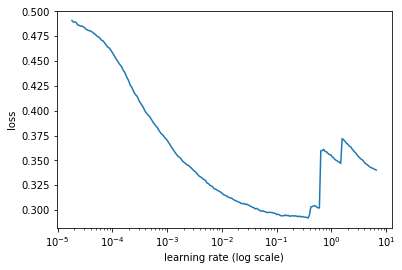

In [61]:
m.sched.plot()

In [63]:
lr = 1e-3

In [64]:
m.fit(lr, 2, cycle_len=2)

epoch      trn_loss   val_loss                               
    0      0.27147    0.256383  
    1      0.264363   0.254738                               
    2      0.262845   0.250042                               
    3      0.258755   0.249286                               



[array([0.24929])]

In [65]:
m.fit(lr, 2, cycle_len=2)

epoch      trn_loss   val_loss                               
    0      0.256924   0.247998  
    1      0.251423   0.24747                                
    2      0.255572   0.246624                               
    3      0.252806   0.246269                               



[array([0.24627])]

In [66]:
m.fit(lr, 2, cycle_len=2)

epoch      trn_loss   val_loss                               
    0      0.254826   0.246499  
    1      0.251878   0.245159                               
    2      0.247309   0.245104                               
    3      0.248259   0.244797                               



[array([0.2448])]

In [67]:
m.fit(lr, 5, wds=1e-7, cycle_len=3, best_save_name="best_home_default1")

epoch      trn_loss   val_loss                               
    0      0.247379   0.245071  
    1      0.243773   0.243696                               
    2      0.247241   0.243674                               
    3      0.245972   0.244296                               
    4      0.245579   0.243668                               
    5      0.242039   0.243198                               
    6      0.244097   0.243865                               
    7      0.245528   0.24345                                
    8      0.239846   0.243362                               
    9      0.24239    0.24446                                
    10     0.241799   0.243839                               
    11     0.237985   0.243767                               
    12     0.239509   0.244237                               
    13     0.239464   0.244311                               
    14     0.237356   0.244196                               



[array([0.2442])]

In [68]:
m.fit(lr/10, 2, cycle_len=2, wds=1e-7, best_save_name="best_home_default2")

epoch      trn_loss   val_loss                               
    0      0.233641   0.244234  
 52%|█████▏    | 119/231 [00:05<00:05, 20.97it/s, loss=0.235]

KeyboardInterrupt: 

In [69]:
m.load(name="best_home_default1")

In [70]:
x1,y1=m.predict_with_targs()

In [72]:
test_df

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,PREV APP COUNT,TOTAL PREV LOAN AMT,SK_ID_PREV,AMT_ANNUITY_PAVG,AMT_APPLICATION,AMT_CREDIT_PAVG,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE_PAVG,HOUR_APPR_PROCESS_START_PAVG,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_TYPE_BAVG,WEEKDAY_APPR_PROCESS_START_BAVG,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE_BAVG,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION,SK_ID_PREV_CCAVG,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_CCAVG,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_BAVG,MONTHS_BALANCE_B_B,STATUS,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD_CAVG,SK_DPD_DEF_CAVG,NAME_CONTRACT_STATUS_CAVG,SK_ID_PREV_IAVG,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR_CNT_BUREAU,SK_ID_CURR_CNT_CRED_CARD,SK_ID_CURR_CNT_POS_CASH,SK_ID_CURR_CNT_INSTALL,SK_ID_PREV_add_1,NAME_C

In [71]:
pred_test=m.predict(True)

RuntimeError: running_mean should contain 161 elements not 159